In [2]:
import numpy as np
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt
from scipy.linalg import eig
from cycler import cycler
import pandas as pd
import seaborn as sns

plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

def svd_jacs(test_id_first, start, end, interval, seed, sigmas):
    jacs = {i:[] for i in range(start, end, interval)}
    us = {i:[] for i in range(start, end, interval)}
    vts = {i:[] for i in range(start, end, interval)}
    test_id = test_id_first + str(seed)
    for i in range(start, end, interval):
        str_i = f'{i:04d}'
        mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy')
        if sigmas:
            L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
            mat = mat.T @ inv(L[0]) @ mat  #共轭转置
        else:
            mat = mat.T @ mat
        u, s, vt = np.linalg.svd(mat)
        jacs[i].append(s)
        us[i].append(u)
        vts[i].append(vt)

    return jacs, us, vts

def plot_singular_cum(test_id_first, seed = 0, window=5, window2='all', start=1, end=16435, interval=108, seq_len=30, sigmas=True):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    singular, us, vts = svd_jacs(test_id_first, start, end, interval, seed, sigmas)
    gn_dic = {}
    fig1, ax1 = plt.subplots(figsize=(5, 4), dpi=150)
    fig2, ax2 = plt.subplots(figsize=(5, 4), dpi=150)

    for i in range(start, end, interval):
        time = start_date + pd.Timedelta(days=i)
        jac_arr = np.array(singular[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean_cum = np.cumsum(jac_mean)
        jac_mean_cum /= jac_mean_cum[-1]
        gn = gini(jac_mean_cum)
        gn_dic[time.strftime("%Y-%m-%d")] = gn
        time2 = start_date + pd.Timedelta(days=i+seq_len)
    
        ax1.plot(jac_mean[:window], 
                label=time2.strftime("%Y-%m-%d"), 
                alpha=0.5)
        # plt.fill_between(range(window), jac_mean[:window]+jac_std[:window], jac_mean[:window]-jac_std[:window], alpha=0.15)

        if window2 == 'all':
            ax2.plot(jac_mean_cum, 
                    label=time2.strftime("%Y-%m-%d"), 
                    alpha=0.5)
        else:
            ax2.plot(jac_mean_cum[:window2], 
                    label=time2.strftime("%Y-%m-%d"), 
                    alpha=0.5)
    ax2.set_xlabel("singular value index")
    #plt.xticks(range(window), [1+i for i in range(window)])
    ax2.set_ylabel("singular cumsum(normalized)")
    # plt.ylim([0.4,1])
    # plt.xlim([0,50])
    ax2.legend(loc=[1.01,0])

    ax1.set_xlabel("singular value index")
    ax1.set_xticks(range(window), [1+i for i in range(window)])
    ax1.set_ylabel("singular value")
    ax1.legend(loc=[1.01,0])
 
    return gn_dic, singular, us, vts

def analysis_u(us, seq_len, dims, start, end, interval, target):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    for j in target:
        for i in range(start, end, interval):
            time = start_date + pd.Timedelta(days=i)
            time2 = start_date + pd.Timedelta(days=i+seq_len)
            u = np.array(us[i])
            u_col = u[:, j]
            u_col = u_col.reshape(seq_len,dims,-1)[:,:,0]
            u_col = np.abs(u_col)
            plt.figure()
            sns.heatmap(u_col)
            plt.xlabel('space')
            plt.ylabel('time')
            plt.title(time2.strftime("%Y-%m-%d")+"_index={0}".format(j))
            
    

In [3]:
jac = np.random.rand(2, 3, 4, 5)
flattened = jac.reshape(jac.shape[0]*jac.shape[1], -1).astype(float)
print("展平后形状:", flattened.shape)  # 输出 (6, 20)
a, b, c, d = 2, 3, 4, 5
restored = flattened.reshape(a, b, c, d)

# 验证恢复是否正确
print("恢复后形状:", restored.shape)        # 输出 (2, 3, 4, 5)
print("数据一致性:", np.allclose(jac, restored))  # 输出 True

展平后形状: (6, 20)
恢复后形状: (2, 3, 4, 5)
数据一致性: True


# 日资料分析

In [4]:

start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
end_date = pd.to_datetime("2017-01-01", format="%Y-%m-%d")
#end_time = start_time + pd.Timedelta(days=11687)
days_difference = (end_date - start_date).days
#end_time.strftime("%Y-%m-%d")
days_difference

13880

<ipython-input-2-932d0b2d8c12>:72: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax1.set_xticks(range(window), [1+i for i in range(window)])


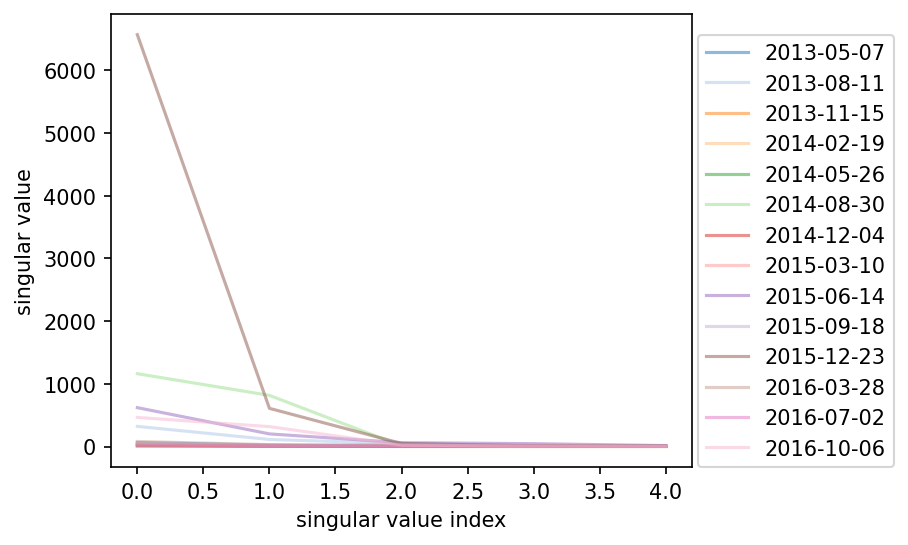

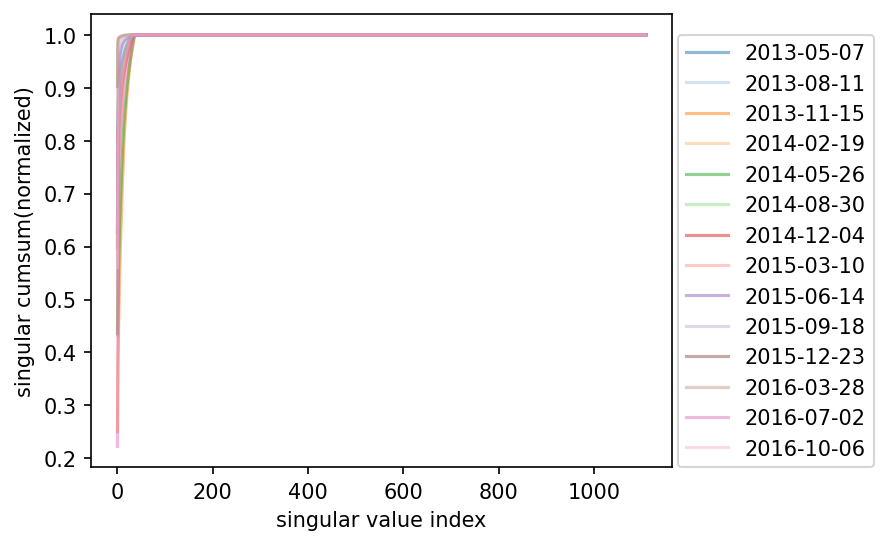

In [5]:
batch_size = 8
test_id = 'long_term_forecast_iT_cov_qbo_daily_1520_iTransformer_cov_QBO_ft-1_sl30_pl30_dm512_nh8_el4_dl1_df512_fc3_flocvali_test_first_lam0.001_dtTrue_Exp_'
gn_dic, singular, us, vts = plot_singular_cum(test_id, seed = 0, start=12515, end=13859, interval=96, sigmas=True)

<ipython-input-2-932d0b2d8c12>:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


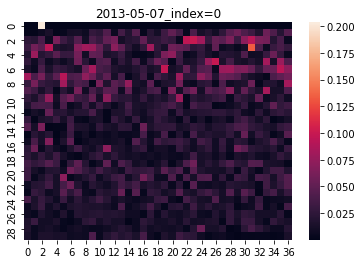

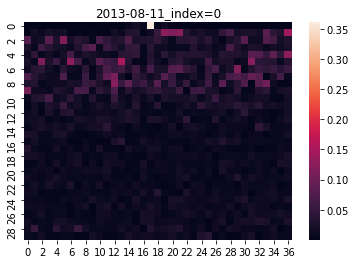

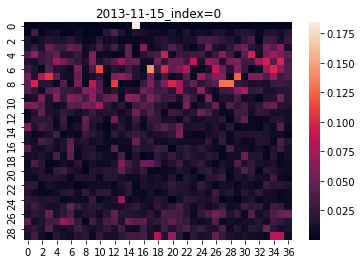

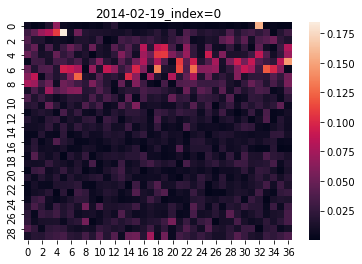

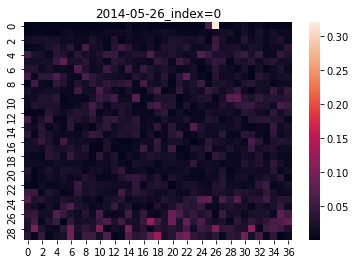

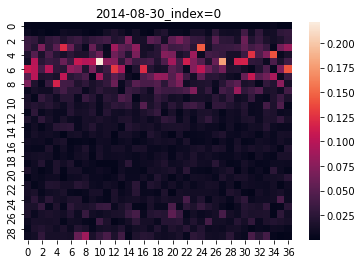

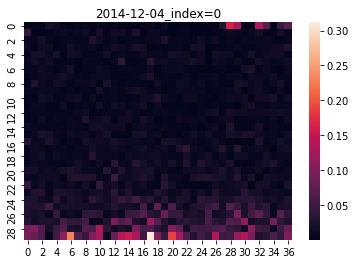

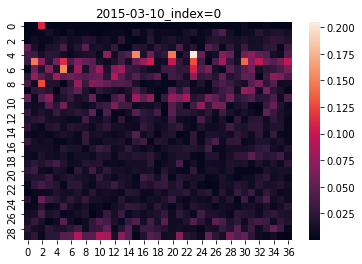

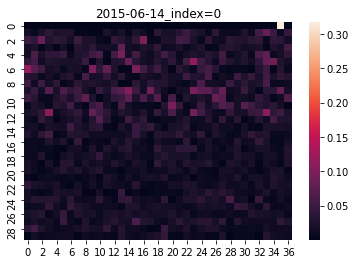

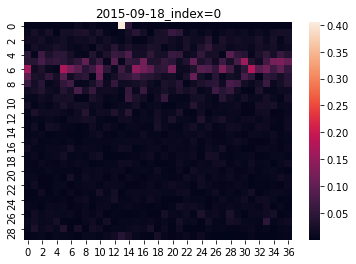

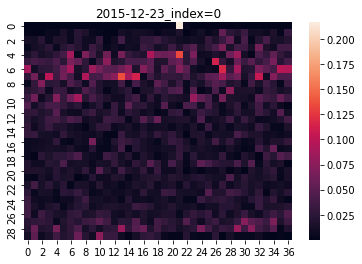

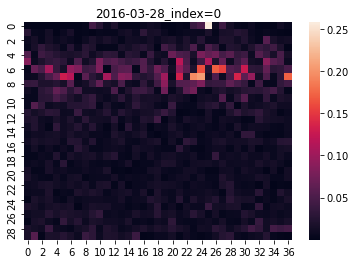

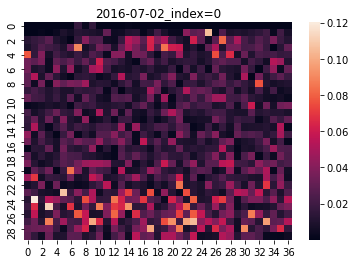

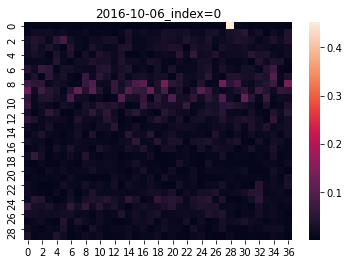

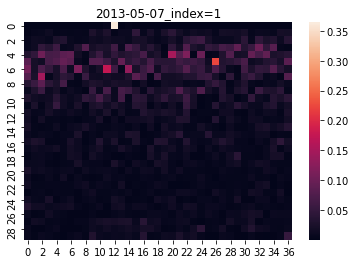

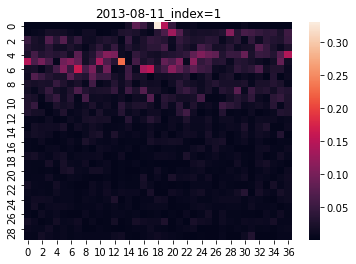

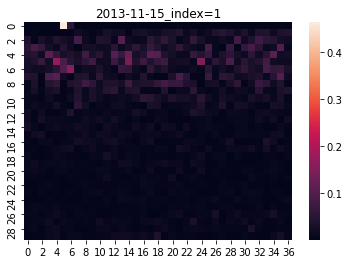

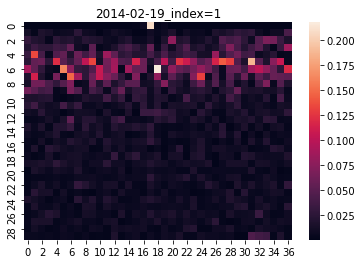

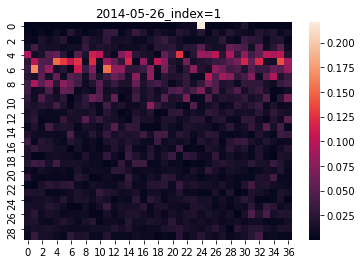

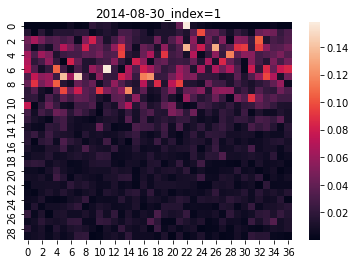

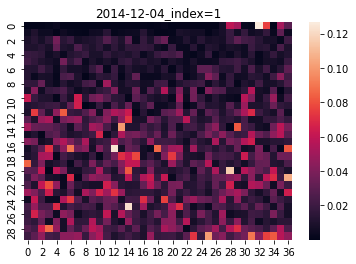

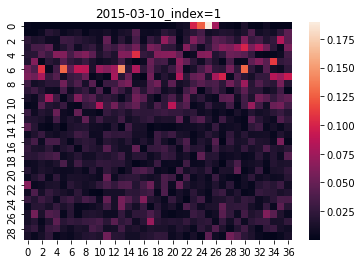

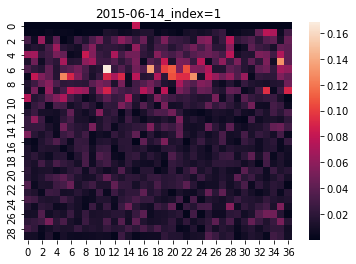

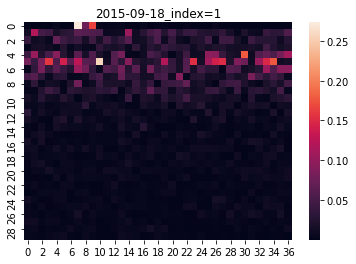

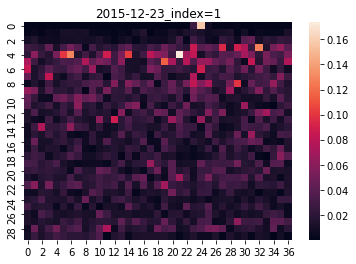

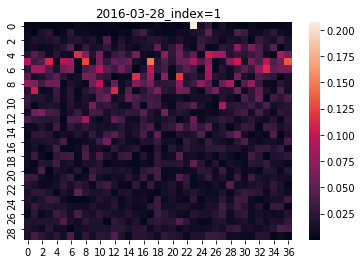

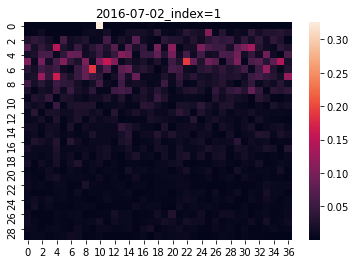

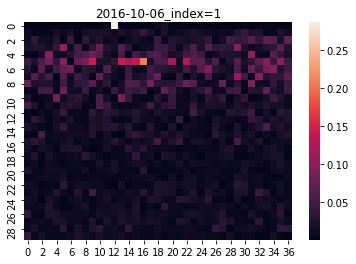

In [6]:
analysis_u(us, seq_len=30, dims=37, start=12515, end=13859, interval=96, target=[0,1])

In [12]:
us[12515],us[12515][0].shape

([array([[-2.36118688e-05-2.58297493e-05j,  3.33870917e-06-4.35648667e-06j,
          -2.03548809e-01-8.38066065e-05j, ...,
          -2.04002144e-03+1.38317943e-04j, -1.45731517e-03-3.03566669e-03j,
          -9.47030345e-03-1.02350405e-02j],
         [-2.86117528e-05-3.22957668e-05j,  8.61403755e-06-4.35656433e-06j,
          -5.83278606e-05+3.09887515e-05j, ...,
           9.33629689e-04+2.00547113e-03j,  3.95668662e-03-5.53939899e-03j,
           2.18468590e-02-4.75966239e-02j],
         [-1.07383446e-05+1.58327288e-05j, -1.58714663e-05-2.36135497e-06j,
           8.96309428e-05+4.94883668e-06j, ...,
           1.74971709e-04-3.49411789e-04j,  1.50200041e-03+1.51049520e-03j,
           4.67329052e-03-2.31173041e-02j],
         ...,
         [ 7.54870790e-03+9.49049067e-03j,  1.08421747e-04-5.32017623e-05j,
          -4.60525641e-06+4.08559449e-05j, ...,
           5.71700593e-03+7.94813251e-03j, -5.79212764e-04+8.50951116e-03j,
           1.97211013e-05-3.96500293e-04j],
         [

{'2013-04-07': 0.49943598244963416,
 '2013-07-12': 0.4994364938759144,
 '2013-10-16': 0.49942652404431265,
 '2014-01-20': 0.49943578805695965,
 '2014-04-26': 0.49963319681336227,
 '2014-07-31': 0.4993884180994096,
 '2014-11-04': 0.4994341070556457,
 '2015-02-08': 0.4994351361681979,
 '2015-05-15': 0.4994324262406903,
 '2015-08-19': 0.49943699041161127,
 '2015-11-23': 0.49943673603509364,
 '2016-02-27': 0.4994146747000834,
 '2016-06-02': 0.49942616695190467,
 '2016-09-06': 0.49938598427007586}

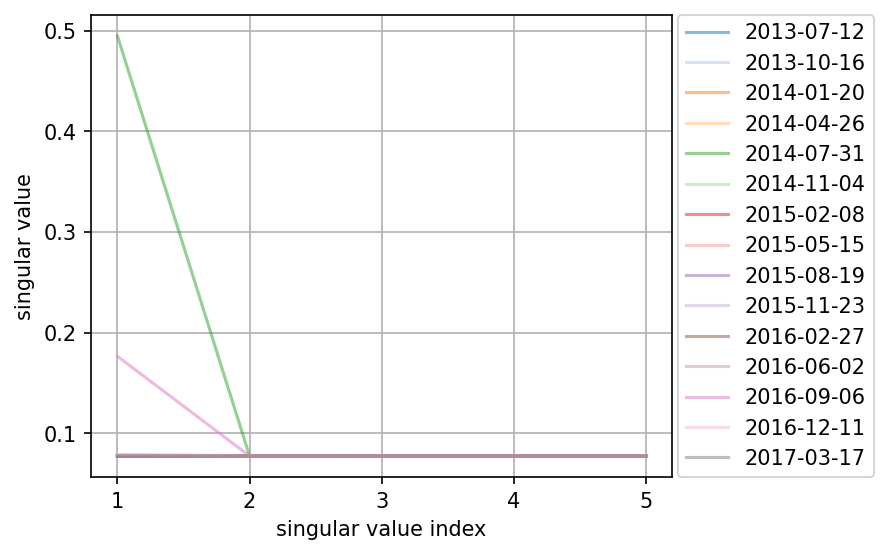

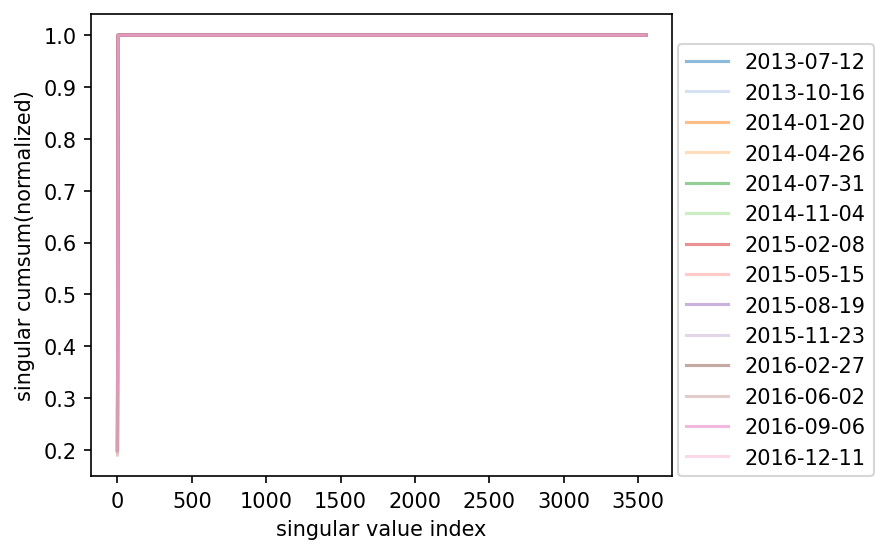

In [10]:
batch_size = 8
test_id = 'long_term_forecast_iT_cov_qbo_daily_1520_iTransformer_cov_QBO_ft5_sl96_pl96_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=96, dims=5, start=12515, end=13859, interval=96, window=5, sigmas=True)
plot_singular_cum(test_id, seeds = 1, length=96, dims=5, start=12515, end=13859, interval=96, window='all', sigmas=True, figure_show=True)

{'2017-12-31': 0.4993999754355667,
 '2018-04-06': 0.4993799623924047,
 '2018-07-11': 0.4994343399052622,
 '2018-10-15': 0.49942613612869946,
 '2019-01-19': 0.499401016780339,
 '2019-04-25': 0.49943687229036904,
 '2019-07-30': 0.4994342416326458,
 '2019-11-03': 0.4993941130353845,
 '2020-02-07': 0.4994360742973103,
 '2020-05-13': 0.49943695664733256,
 '2020-08-17': 0.49943698049802987,
 '2020-11-21': 0.49940069834691325}

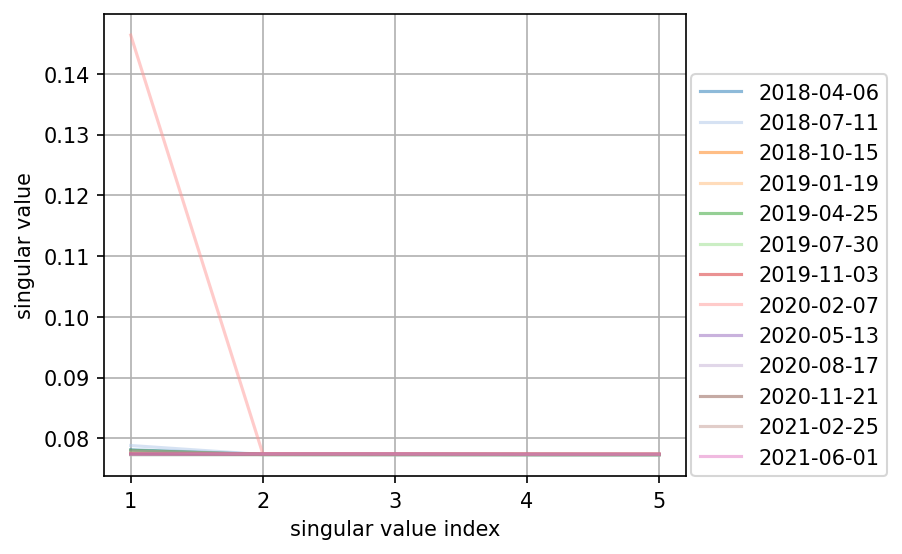

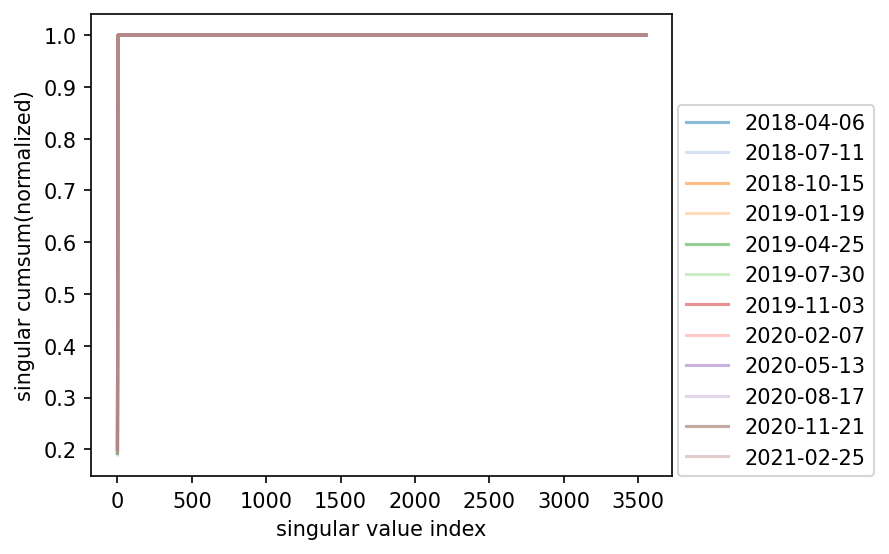

In [7]:
batch_size = 8
test_id = 'long_term_forecast_iT_cov_qbo_daily_1520_rbt_iTransformer_cov_QBO_ft5_sl96_pl96_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=96, dims=5, start=14244, end=15396, interval=96, window=5, sigmas=True)
plot_singular_cum(test_id, seeds = 1, length=96, dims=5, start=14244, end=15396, interval=96, window='all', sigmas=True, figure_show=True)

{'2017-12-30': 0.49943463948136213,
 '2018-04-05': 0.4994344146686557,
 '2018-07-10': 0.4994274183694105,
 '2018-10-14': 0.49962129434643765,
 '2019-01-18': 0.4993908414473285,
 '2019-04-24': 0.49943693398093136,
 '2019-07-29': 0.4994317460047283,
 '2019-11-02': 0.49942997093680297,
 '2020-02-06': 0.49943695595773296,
 '2020-05-12': 0.4994369831863602,
 '2020-08-16': 0.4994369800851237,
 '2020-11-20': 0.4994314074968129}

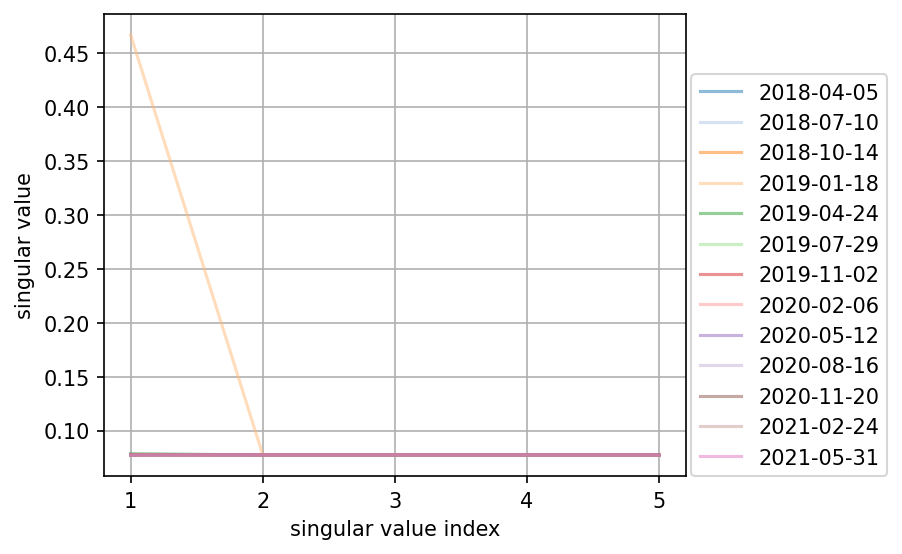

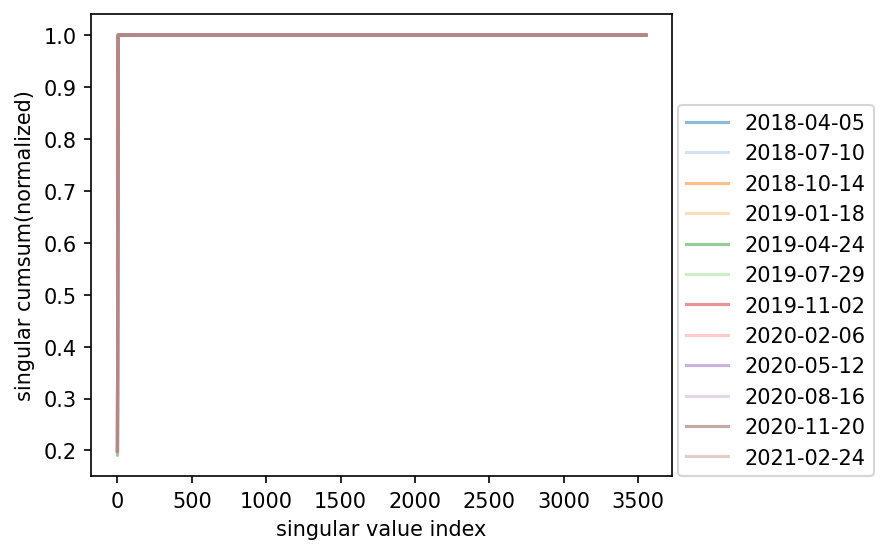

In [6]:
batch_size = 8
test_id = 'long_term_forecast_iT_cov_qbo_daily_1520_iTransformer_cov_QBO_ft5_sl96_pl96_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=96, dims=5, start=14243, end=15395, interval=96, window=5, sigmas=True)
plot_singular_cum(test_id, seeds = 1, length=96, dims=5, start=14243, end=15395, interval=96, window='all', sigmas=True, figure_show=True)

{'2018-03-01': 0.4994375221653695,
 '2018-06-05': 0.4994377311915116,
 '2018-09-09': 0.499437727626156,
 '2018-12-14': 0.4994377315359756,
 '2019-03-20': 0.49943783273421694,
 '2019-06-24': 0.4994374919565967,
 '2019-09-28': 0.49943821174241676,
 '2020-01-02': 0.499437696861485,
 '2020-04-07': 0.4994310395602497,
 '2020-07-12': 0.49943744799318546,
 '2020-10-16': 0.49943593833440325,
 '2021-01-20': 0.4994377495747774}

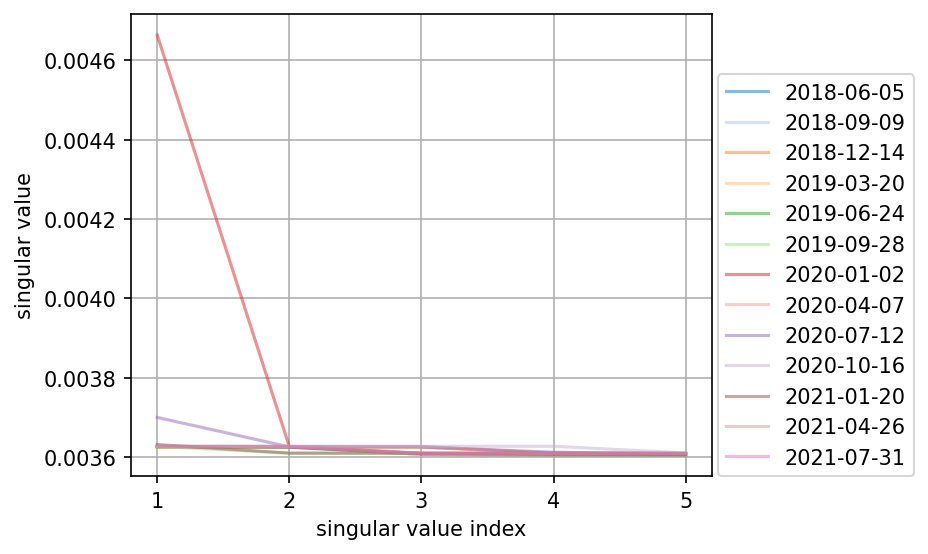

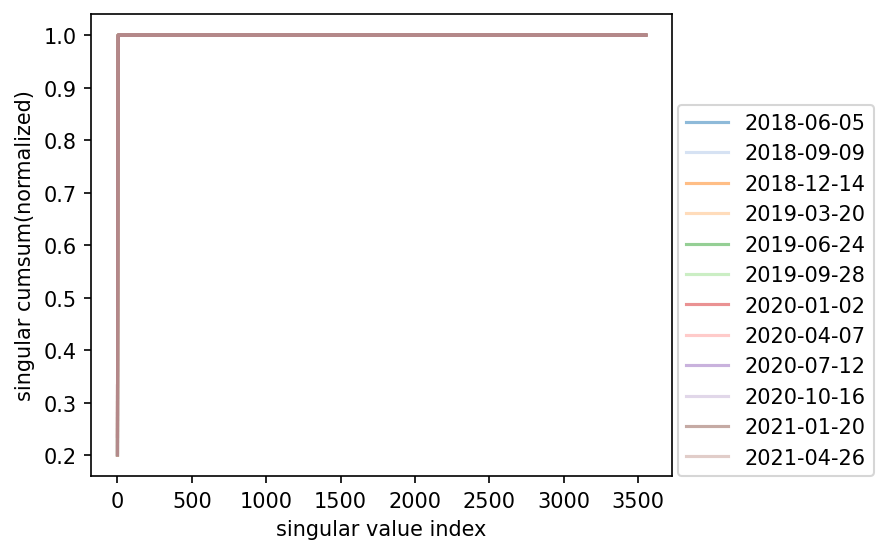

In [8]:
batch_size = 8
test_id = 'long_term_forecast_iT_cov_qbo_daily_1520_iTransformer_cov_QBO_ft5_sl96_pl12_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, dims=5, start=14304, end=15456, interval=96, window=5, sigmas=True)
plot_singular_cum(test_id, seeds = 1, length=12, dims=5, start=14304, end=15456, interval=96, window='all', sigmas=True, figure_show=True)

{'2013-03-03': 0.4994364302735901,
 '2013-06-07': 0.49943315174125247,
 '2013-09-11': 0.499437127990746,
 '2013-12-16': 0.4994377085497459,
 '2014-03-22': 0.49943098362099037,
 '2014-06-26': 0.4994375103823925,
 '2014-09-30': 0.4994373190493141,
 '2015-01-04': 0.49940504575150646,
 '2015-04-10': 0.4994375717101558,
 '2015-07-15': 0.49943575073484214,
 '2015-10-19': 0.4994368773278173,
 '2016-01-23': 0.4994310453001235,
 '2016-04-28': 0.49943433004785864,
 '2016-08-02': 0.49943686680434896}

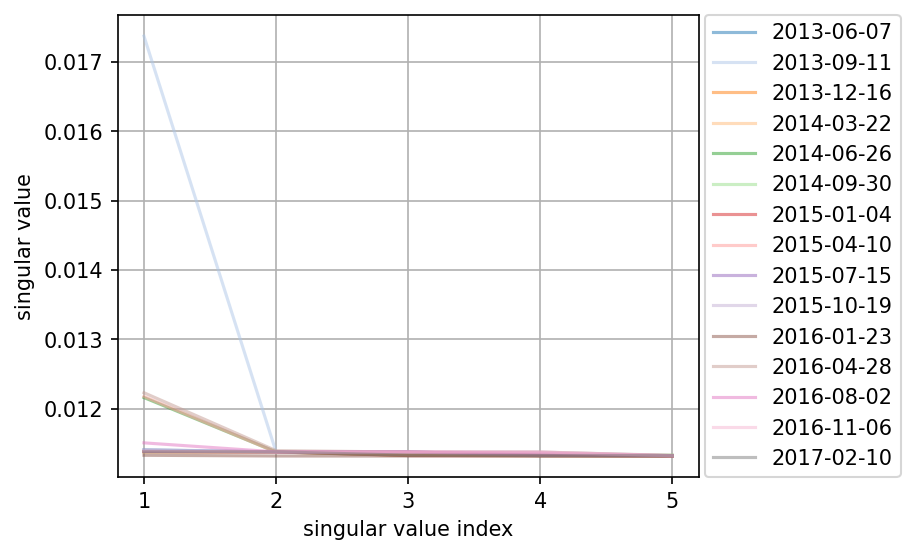

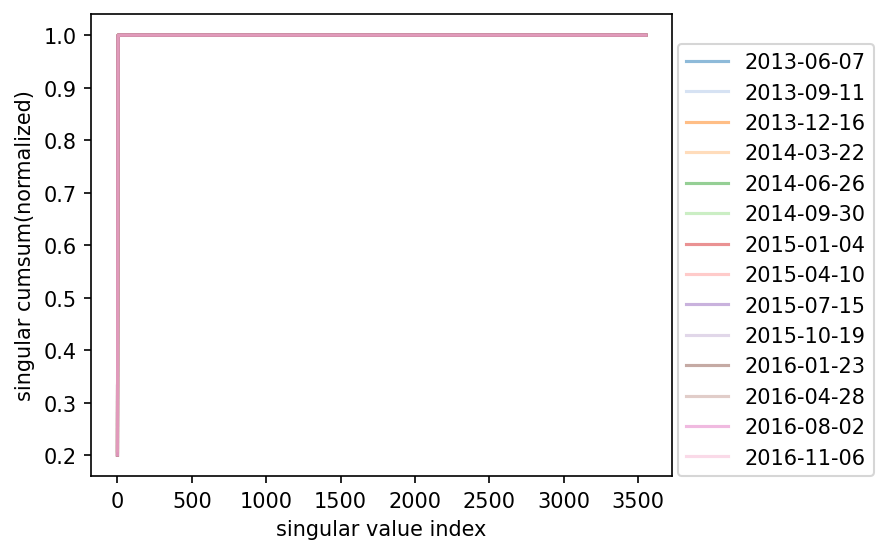

In [10]:
batch_size = 8
test_id = 'long_term_forecast_iT_cov_qbo_daily_1520_iTransformer_cov_QBO_ft5_sl96_pl12_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, dims=5, start=12480, end=13824, interval=96, window=5, sigmas=False)
plot_singular_cum(test_id, seeds = 1, length=12, dims=5, start=12480, end=13824, interval=96, window='all', sigmas=False, figure_show=True)

{'2018-03-01': 0.49937155492600427,
 '2018-06-05': 0.49985670100602364,
 '2018-09-09': 0.4995033738500738,
 '2018-12-14': 0.49967845790368826,
 '2019-03-20': 0.4994361711335239,
 '2019-06-24': 0.4993709906770991,
 '2019-09-28': 0.4993228909774,
 '2020-01-02': 0.49943697704590373,
 '2020-04-07': 0.4993447566933943,
 '2020-07-12': 0.49941763409125706,
 '2020-10-16': 0.4994348801468518,
 '2021-01-20': 0.4994369102652366}

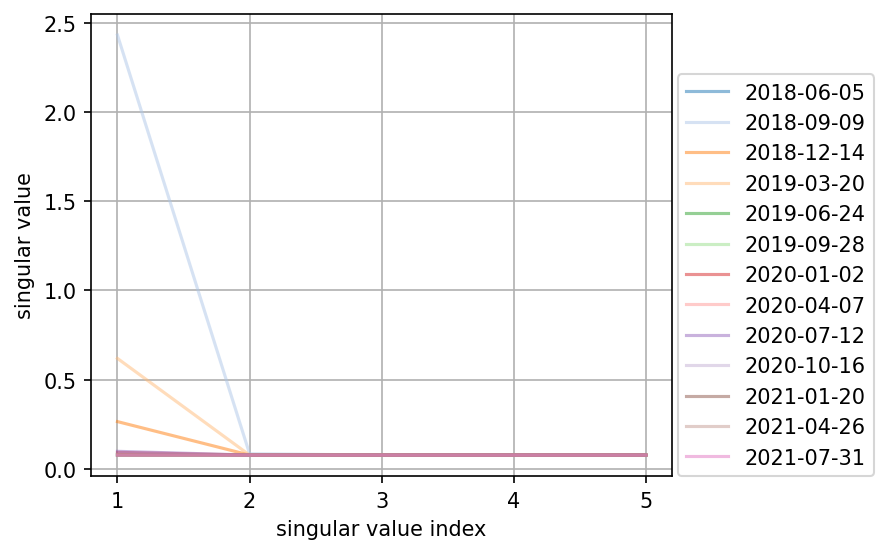

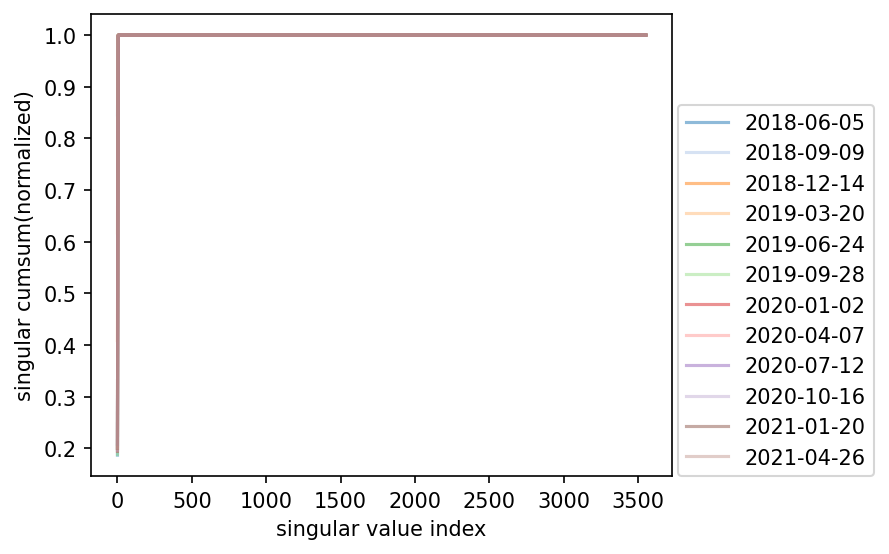

In [4]:
batch_size = 8
test_id = 'long_term_forecast_iT_cov_qbo_daily_1520_rbt_iTransformer_cov_QBO_ft5_sl96_pl96_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=96, dims=5, start=14304, end=15456, interval=96, window=5, sigmas=True)
plot_singular_cum(test_id, seeds = 1, length=96, dims=5, start=14304, end=15456, interval=96, window='all', sigmas=True, figure_show=True)

{'2013-03-03': 0.49942213312675365,
 '2013-06-07': 0.4994360487097548,
 '2013-09-11': 0.49943523493185527,
 '2013-12-16': 0.49943654334746823,
 '2014-03-22': 0.4994355382631883,
 '2014-06-26': 0.4994195040403252,
 '2014-09-30': 0.4994319244649249,
 '2015-01-04': 0.4994344916587785,
 '2015-04-10': 0.4993545118794439,
 '2015-07-15': 0.4994338652879049,
 '2015-10-19': 0.49948611566628387,
 '2016-01-23': 0.49940539219752134,
 '2016-04-28': 0.4993955396430977,
 '2016-08-02': 0.4994368771568908}

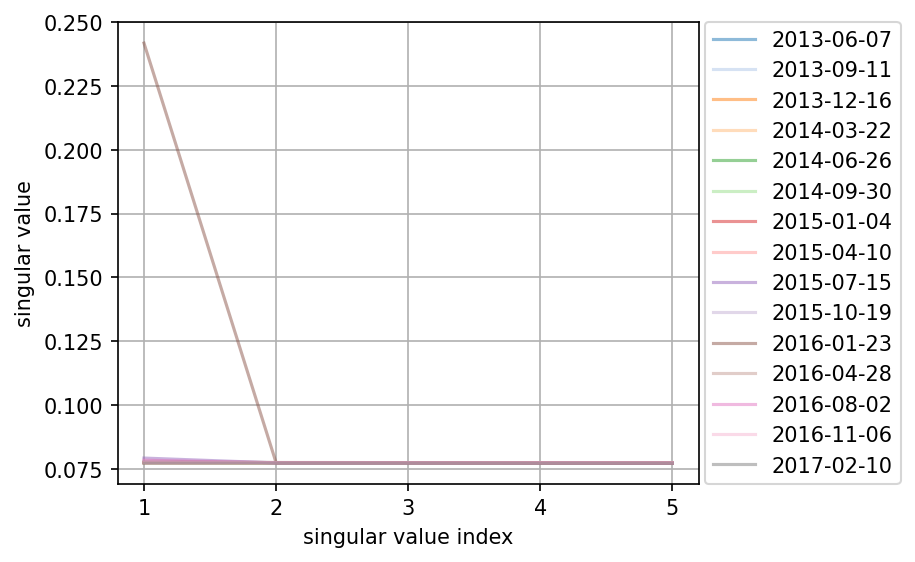

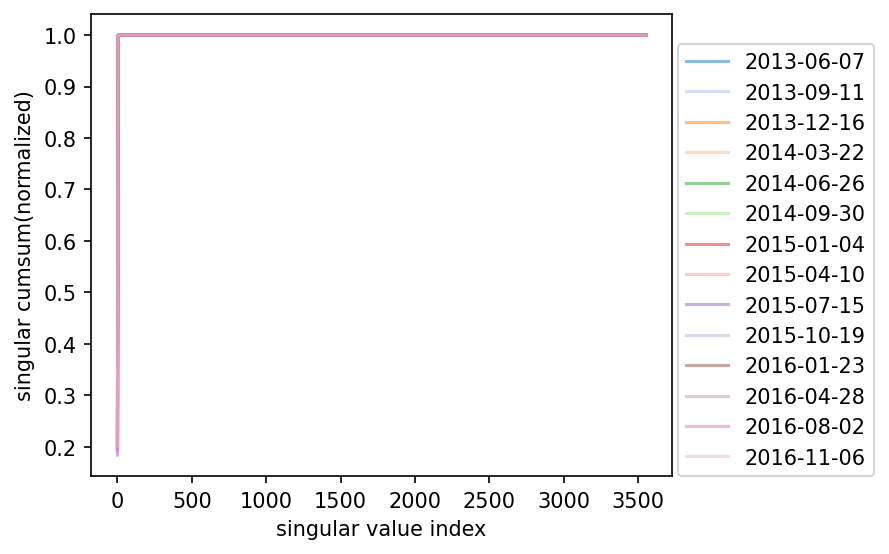

In [6]:
batch_size = 8
test_id = 'long_term_forecast_iT_cov_qbo_daily_1520_iTransformer_cov_QBO_ft5_sl96_pl96_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=96, dims=5, start=12480, end=13824, interval=96, window=5, sigmas=True)
plot_singular_cum(test_id, seeds = 1, length=96, dims=5, start=12480, end=13824, interval=96, window='all', sigmas=True, figure_show=True)

# 其他结果

{'2013-03-03': 0.4994369389832829,
 '2013-06-07': 0.4994369390915926,
 '2013-09-11': 0.4994369428523261,
 '2013-12-16': 0.49943694141055883,
 '2014-03-22': 0.49943678227321475,
 '2014-06-26': 0.49943694003671923,
 '2014-09-30': 0.4994369484550083,
 '2015-01-04': 0.4994369356534134,
 '2015-04-10': 0.4994369378781157,
 '2015-07-15': 0.4994369383431725,
 '2015-10-19': 0.49943659491027614,
 '2016-01-23': 0.49943544927366534,
 '2016-04-28': 0.49943534159141745,
 '2016-08-02': 0.49943693899980224}

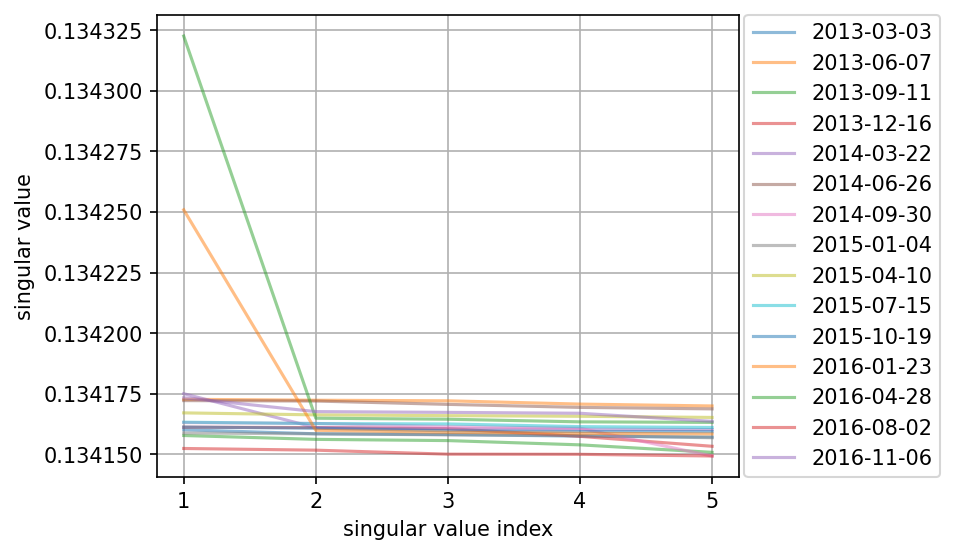

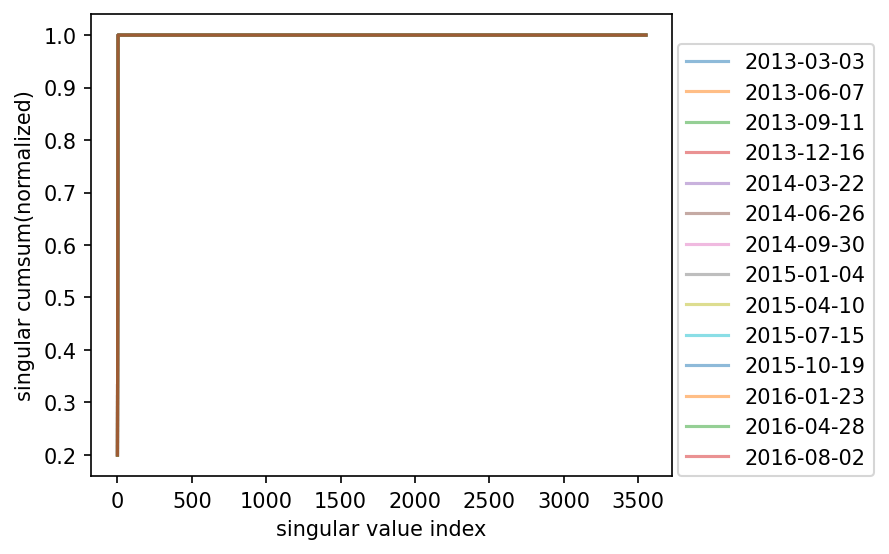

In [24]:
test_id = 'long_term_forecast_iT_cov_qbo_daily_iTransformer_QBO_ft5_sl96_pl96_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.0_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=96, dims=5, start=12480, end=13824, interval=96, window=5, sigmas=False)
plot_singular_cum(test_id, seeds = 1, length=96, dims=5, start=12480, end=13824, interval=96, window='all', sigmas=False, figure_show=True)

# 对f(x)的Jacobian矩阵做SVD分解

In [2]:
#test_id_first = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl1_pl1_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"
def plot_singular(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_std = np.std(jac_arr, axis=0)


        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)
        plt.fill_between(range(window), jac_mean[:window]+jac_std[:window], jac_mean[:window]-jac_std[:window], alpha=0.15)
    plt.grid()
    plt.xlabel("singular value index")
    plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular value")
    plt.legend(loc=[1.01,0])
    
#plot_singular(test_id_first, seeds=1, length=1)

In [12]:
from scipy.linalg import eig

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

test_id = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'    
def plot_singular_cum(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            #mat = mat.T @ inv(msed) @ mat
#             eigenvalues, eigenvectors = eig(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    gn_dic = {}
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean = np.cumsum(jac_mean)
        jac_mean /= jac_mean[-1]
        gn = gini(jac_mean)
        gn_dic[str(1941+i//12)] = gn
        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)

    plt.xlabel("singular value index")
    #plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular cumsum(normalized)")
    plt.ylim([0.4,1])
    plt.xlim([0,50])
    plt.legend(loc=[1.01,0])
    return gn_dic
    

{'2012': 0.49165494044957314,
 '2013': 0.48574397714812023,
 '2014': 0.48079627094885424,
 '2015': 0.4951347171992805,
 '2016': 0.48587819172027036,
 '2017': 0.48989277624858296,
 '2018': 0.4933395682578553,
 '2019': 0.48694530395924673,
 '2020': 0.48845702101878885}

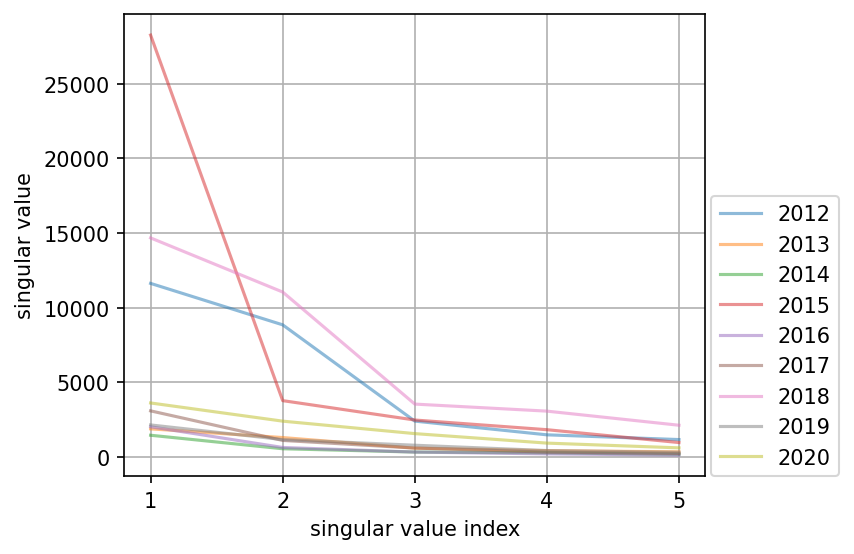

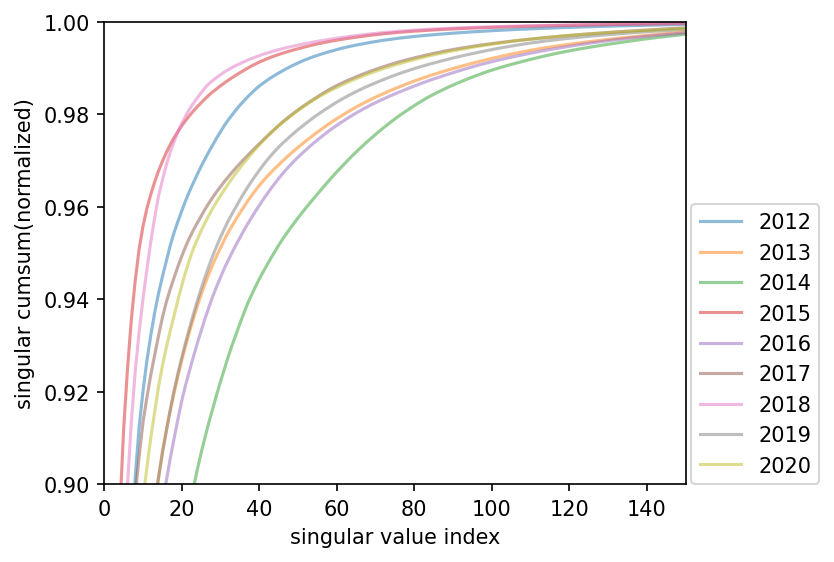

In [8]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.46882739126864637,
 '2013': 0.46297571668501103,
 '2014': 0.46432941514132575,
 '2015': 0.485812143761151,
 '2016': 0.46455903133196075,
 '2017': 0.4636361990094394,
 '2018': 0.48728600061415617,
 '2019': 0.4650025419339191,
 '2020': 0.48979090001029524}

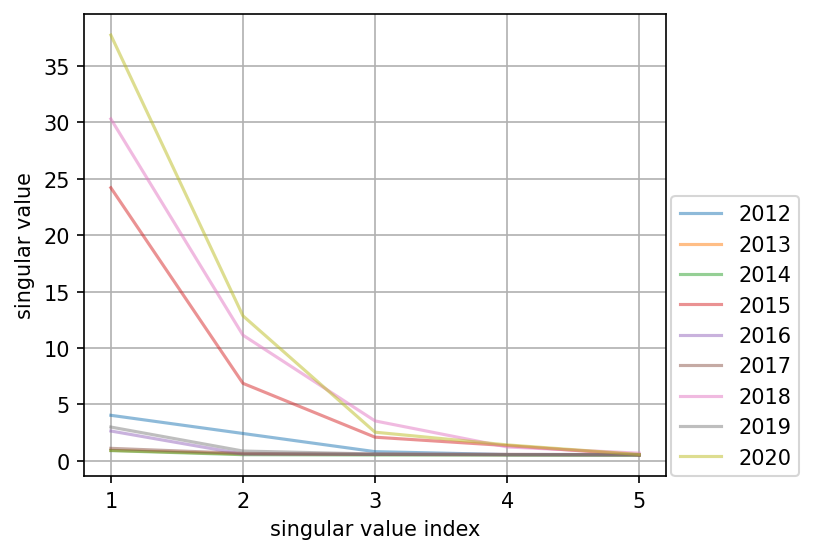

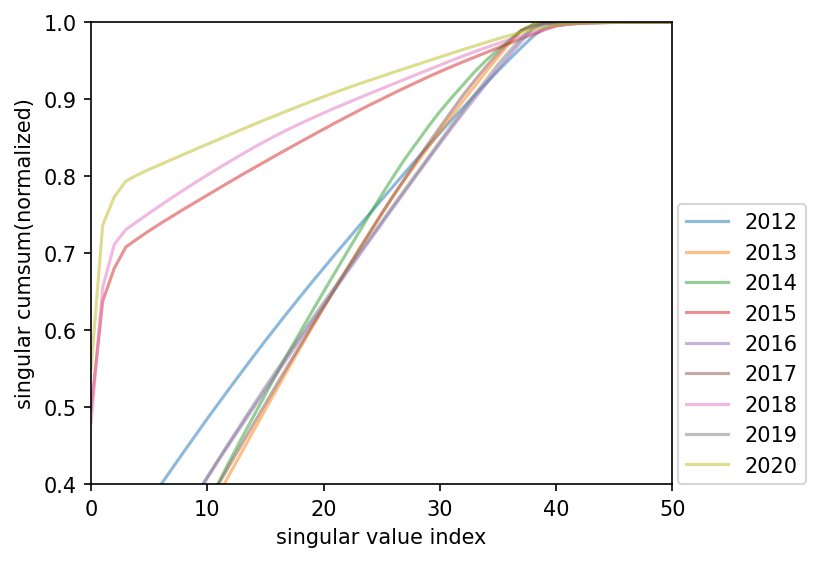

In [13]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.4888285402201138,
 '2013': 0.47988910520051764,
 '2014': 0.4837338777626421,
 '2015': 0.49367503342943186,
 '2016': 0.4826291302058978,
 '2017': 0.4790586287605122,
 '2018': 0.49257027250696517,
 '2019': 0.48480844346317176,
 '2020': 0.4943837218406518}

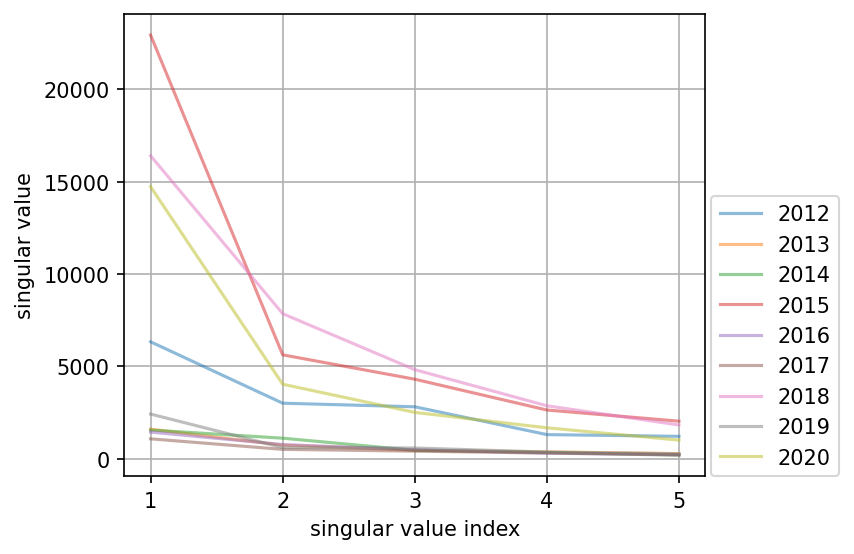

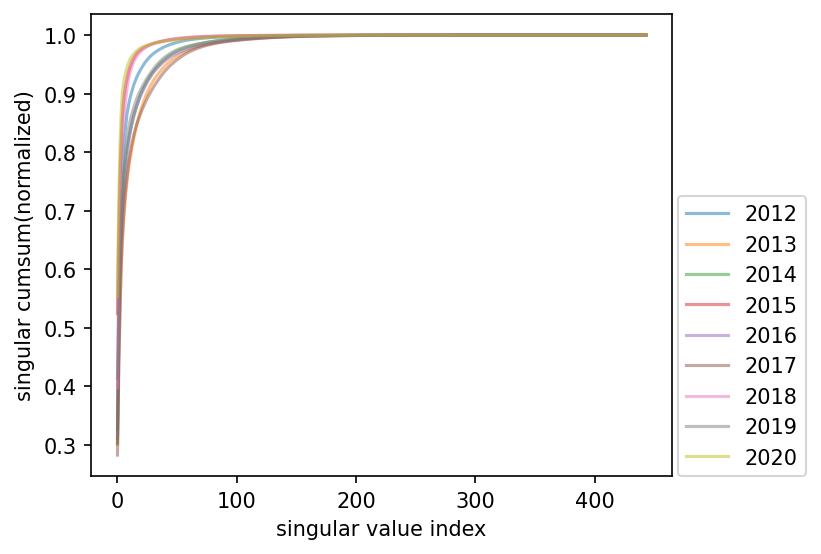

In [4]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.0_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.4630018170385376,
 '2013': 0.46224250516682075,
 '2014': 0.4624851810271845,
 '2015': 0.46182952496477014,
 '2016': 0.4626919236088003,
 '2017': 0.46411287126077316,
 '2018': 0.46191611936155363,
 '2019': 0.463875109049132,
 '2020': 0.4615913403378955}

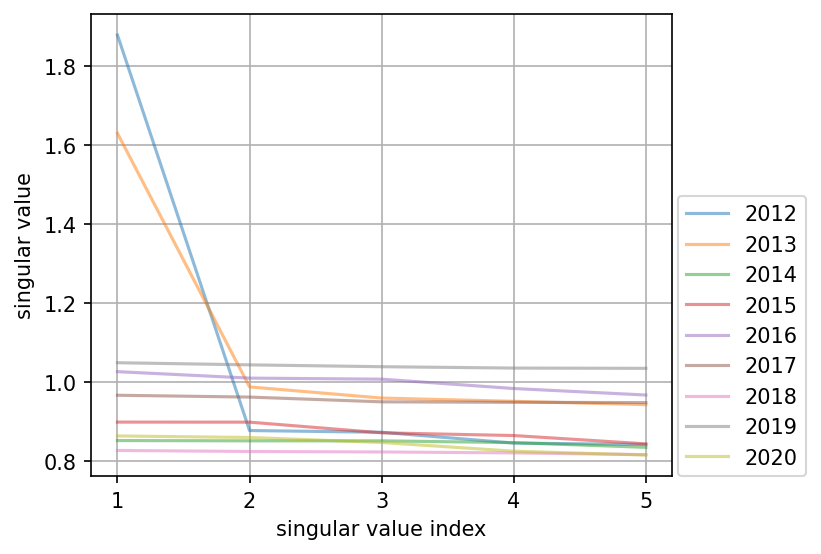

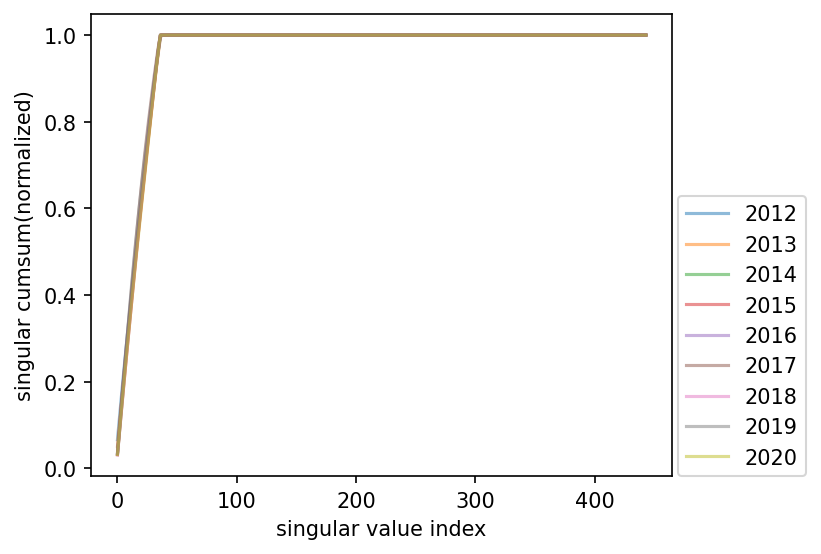

In [6]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.02_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.48590747474373874,
 '2013': 0.4895152647380705,
 '2014': 0.46569377657198396,
 '2015': 0.4959524702032144,
 '2016': 0.46579055763141886,
 '2017': 0.48178316621690553,
 '2018': 0.49992940912820594,
 '2019': 0.4847818354772516,
 '2020': 0.46905325741605775}

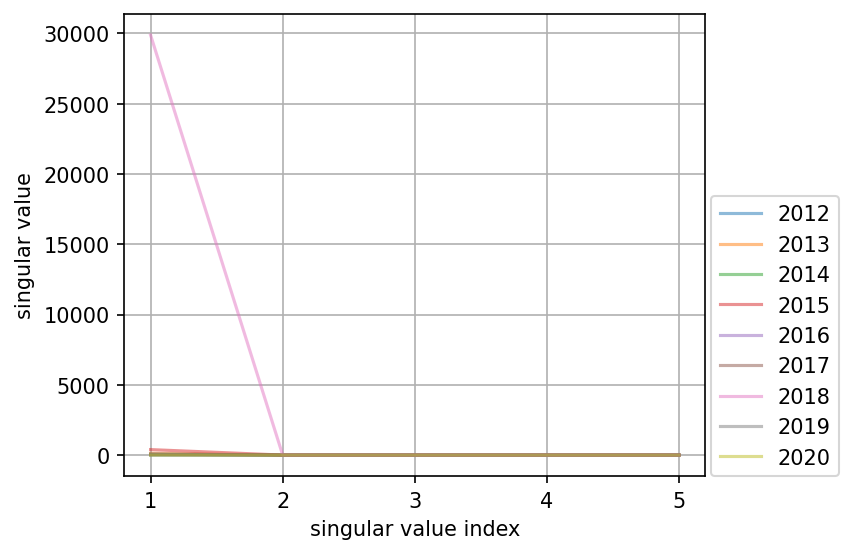

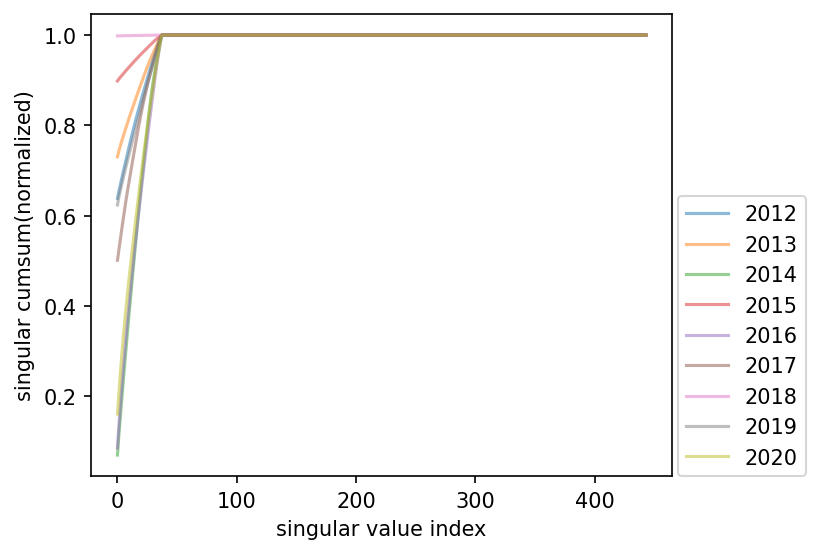

In [8]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.0005_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.4192268132761324,
 '2013': 0.39242569156887785,
 '2014': 0.3960491861568777,
 '2015': 0.43173446719029285,
 '2016': 0.3922501151393507,
 '2017': 0.3895384748438233,
 '2018': 0.43391443776061167,
 '2019': 0.3956114377996274,
 '2020': 0.4202196331490061}

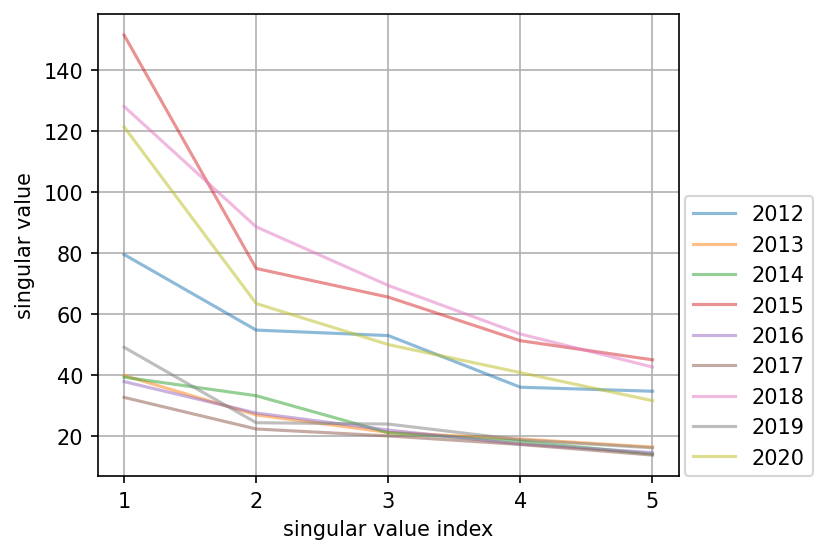

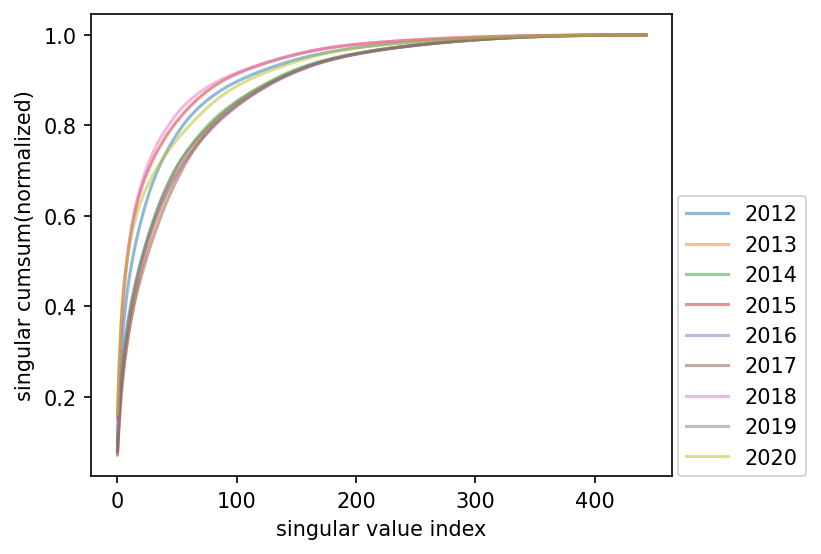

In [9]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.4235649840392566,
 '2013': 0.3923815865379351,
 '2014': 0.3846927954140963,
 '2015': 0.428357511175966,
 '2016': 0.386683695297121,
 '2017': 0.40092965154105975,
 '2018': 0.4366641201868796,
 '2019': 0.397507267454158,
 '2020': 0.4039684926087005}

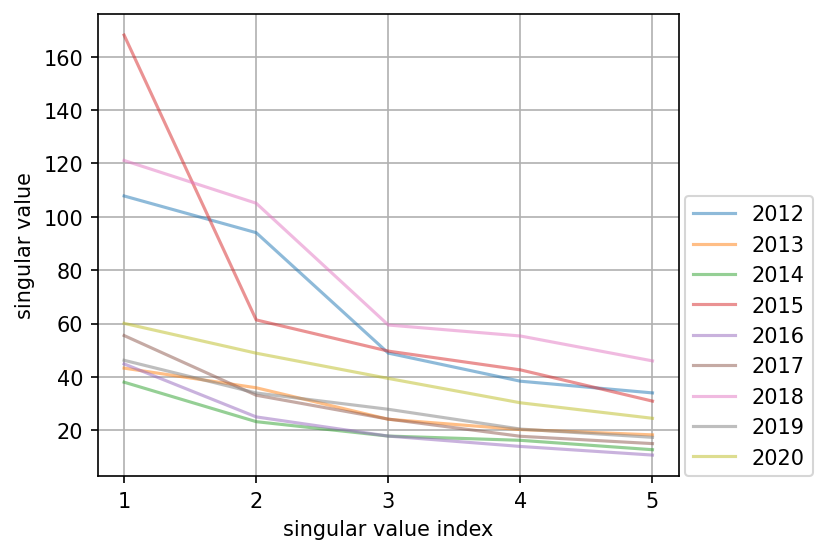

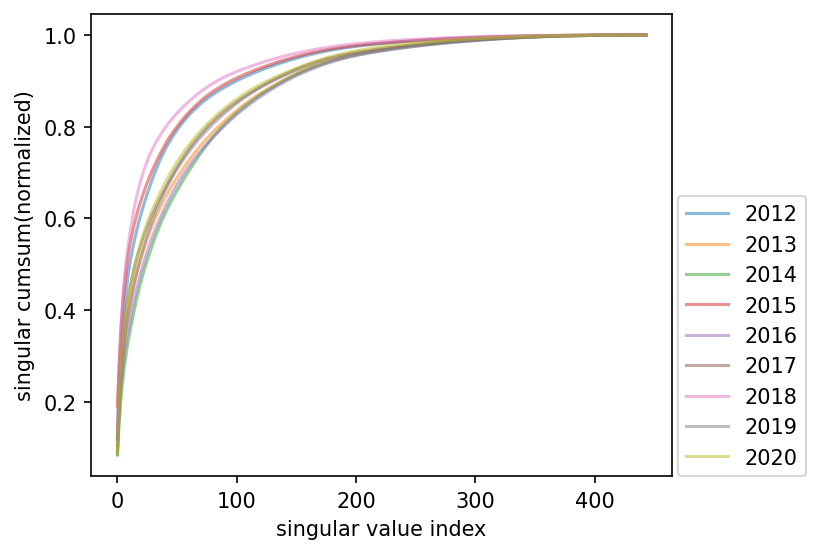

In [5]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
test_id0 = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'
#test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
#plot_singular(test_id0, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
#gn_dic0 = plot_singular_cum(test_id0, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': np.float64(0.4127916855838143),
 '2013': np.float64(0.4034898068651721),
 '2014': np.float64(0.39813582384693424),
 '2015': np.float64(0.4133884032923364),
 '2016': np.float64(0.3958277977029685),
 '2017': np.float64(0.3965376226459141),
 '2018': np.float64(0.4122596433601924),
 '2019': np.float64(0.40057195660876466),
 '2020': np.float64(0.4043368074273893)}

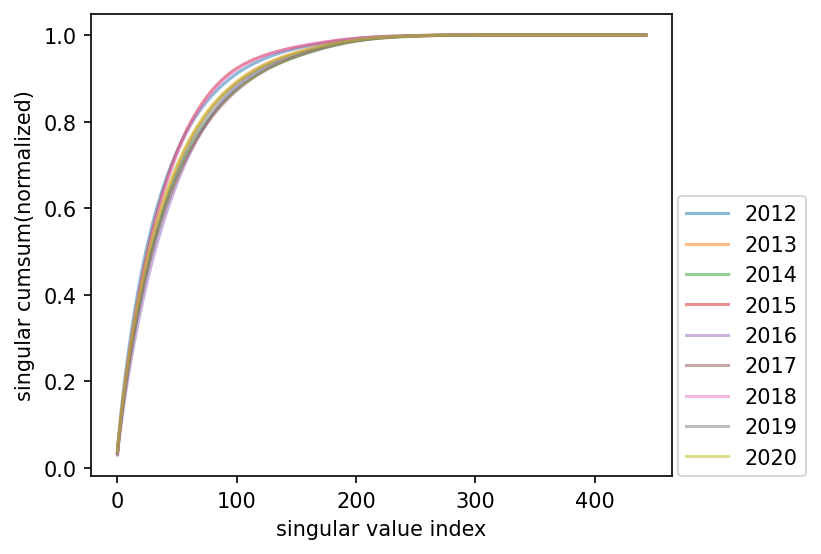

In [4]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': np.float64(0.4632452635422548),
 '2013': np.float64(0.47986298006084493),
 '2014': np.float64(0.46125682415531477),
 '2015': np.float64(0.4672404643840503),
 '2016': np.float64(0.4290361281506142),
 '2017': np.float64(0.4374336897944233),
 '2018': np.float64(0.449221766773663),
 '2019': np.float64(0.4295127090329538),
 '2020': np.float64(0.437953179509767)}

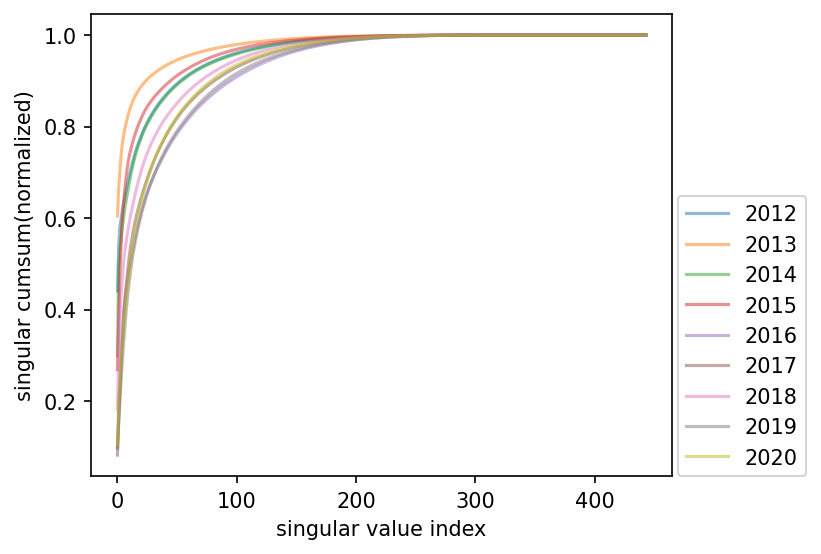

In [5]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

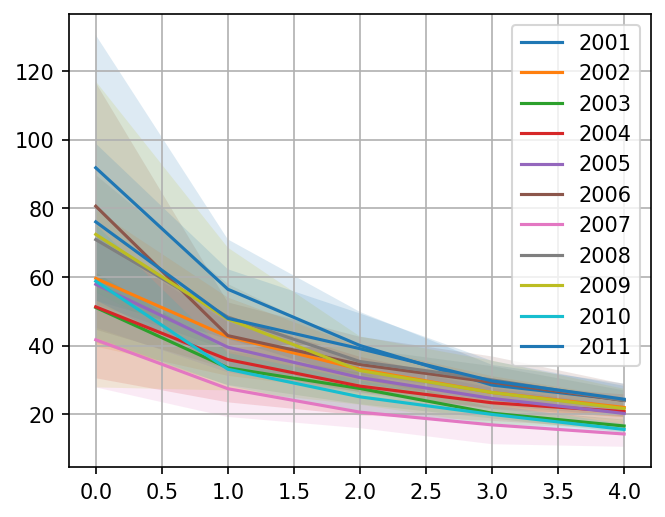

In [67]:
jacs = {i:[] for i in range(720, 852, 12)}
seeds = 10
for expid in range(seeds):
    test_id = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"+str(expid)
    for i in range(720, 852, 12):
        str_i = f'{i:04d}'
        mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(12*36, -1).astype(float)
        u, s, vt = np.linalg.svd(mat)
        jacs[i].append(s) 

plt.figure(figsize=(5,4),dpi=150)
for i in range(720, 852, 12):
    jac_arr = np.array(jacs[i])
    jac_mean = np.mean(jac_arr, axis=0)
    jac_std = np.std(jac_arr, axis=0)
    
    
    plt.plot(jac_mean[:5], label=str(1941+i//12))
    plt.fill_between(range(5), jac_mean[:5]+jac_std[:5], jac_mean[:5]-jac_std[:5], alpha=0.15)
plt.grid()
plt.legend()